# WCG + KNN + XGBoost Soft Voting Ensemble

wcg_knn.ipynbのKNNモデルにXGBoostを追加してsoft votingアンサンブル

モデル間の相関分析も実施

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')
sns.set_palette('Set2')
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("✗ XGBoost not available")
    raise ImportError("XGBoost is required")

✓ XGBoost available


## データ準備（wcg_knn.ipynbと同じ）

In [2]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
data = pd.concat([train_data, test_data]).reset_index().drop(['index'], axis=1)

str_cols = data.select_dtypes(include=["object"]).columns
data[str_cols] = (data[str_cols]
                .apply(lambda s: s.str.strip())
                .replace(r"^\s*$", np.nan, regex=True))

if "Perished" in data and "Survived" not in data:
    data["Survived"] = 1 - data["Perished"]

data['Surname'] = data['Name'].apply(lambda x: x.split(',')[0])

# Ticket_id と Group_id
data['Ticket_id'] = (data['Pclass'].astype(str) + '-' + 
                     data['Ticket'].str[:-1] + '-' + 
                     data['Fare'].astype(str) + '-' + 
                     data['Embarked'].astype(str))
data['Group_id'] = data['Surname'] + '-' + data['Ticket_id']

# Title
data['Title'] = 'man'
data.loc[data.Sex == 'female', 'Title'] = 'woman'
data.loc[data['Name'].str.contains('Master', na=False), 'Title'] = 'boy'

# WCG識別
data.loc[data.Title == 'man', 'Group_id'] = 'noGroup'
data['WC_count'] = data.loc[data.Title != 'man'].groupby('Group_id')['Group_id'].transform('count')
data.loc[data.WC_count <=1, 'Group_id'] = 'noGroup'

count = 0
for i in range(len(data)):
    if (data.loc[i,'Title'] != 'man') & (data.loc[i,'Group_id'] == 'noGroup'):
        matching = data.loc[(data['Ticket_id'] == data.loc[i, 'Ticket_id']) & (data.Title != 'man'), 'Group_id']
        if len(matching) > 0:
            data.loc[i,'Group_id'] = matching.iloc[0]
            if (data.loc[i, 'Group_id'] != 'noGroup'):
                count += 1

# WCSurvived
data['WCSurvived'] = data.loc[(data.Title != 'man') & (data.Group_id != 'noGroup')].groupby('Group_id').Survived.transform('mean')
test_groups = set(data[891:1309].Group_id.unique()) - set(data[0:891].Group_id.unique())
data.loc[data.Group_id.isin(test_groups), 'WCSurvived'] = 0
data.loc[(data.Group_id.isin(test_groups)) & (data.Pclass != 3), 'WCSurvived'] = 1

# WCG予測
data.loc[891:1308, 'Predict'] = 0
data.loc[(data.index >= 891) & (data.index <= 1308) & (data.Sex == 'female'), 'Predict'] = 1
data.loc[(data.index >= 891) & (data.index <= 1308) & (data.Sex == 'female') & (data['WCSurvived'] == 0), 'Predict'] = 0
data.loc[(data.index >= 891) & (data.index <= 1308) & (data.Title == 'boy') & (data['WCSurvived'] == 1), 'Predict'] = 1

# Pfare
data['Ticket_freq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['Pfare'] = data['Fare'] / data['Ticket_freq']

# データ分割
train_male = data[0:891].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]
test_male = data[891:1309].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]
train_female = data[0:891].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

print("データ準備完了")
print(f"Train male: {len(train_male)}")
print(f"Train female: {len(train_female)}")

データ準備完了
Train male: 537
Train female: 198


In [3]:
# 特徴量とpreprocessor（wcg_knn.ipynbと同じ）
features = ['Pfare', 'Pclass', 'Embarked']
numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

y_m = train_male['Survived']
X_m = train_male[features]
y_f = train_female['Survived']
X_f = train_female[features]

print(f"Features: {features}")

Features: ['Pfare', 'Pclass', 'Embarked']


## モデル定義（wcg_knn.ipynb固定 + XGBoost）

In [4]:
# === 男性モデル（wcg_knn.ipynb: KNN k=1,3,7） ===
male_models = {
    'KNN_1': KNeighborsClassifier(n_neighbors=1),
    'KNN_3': KNeighborsClassifier(n_neighbors=3),
    'KNN_7': KNeighborsClassifier(n_neighbors=7),
    'XGB': XGBClassifier(objective="binary:logistic",
    eval_metric="logloss",
    max_depth=5,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=1.0,
    min_child_weight=1.0,
    n_estimators=500,
    subsample=1.0,
    n_jobs=-1,),
}

# KNN Ensemble (元のモデル)
male_models['KNN_Ensemble'] = VotingClassifier([
    ('knn1', KNeighborsClassifier(n_neighbors=1)),
    ('knn3', KNeighborsClassifier(n_neighbors=3)),
    ('knn7', KNeighborsClassifier(n_neighbors=7))
], voting='hard')

# KNN + XGB Ensemble (新規)
male_models['KNN_XGB_Soft'] = VotingClassifier([
    ('knn1', KNeighborsClassifier(n_neighbors=1)),
    ('knn3', KNeighborsClassifier(n_neighbors=3)),
    ('knn7', KNeighborsClassifier(n_neighbors=7)),
    ('XGB', XGBClassifier(objective="binary:logistic",
    eval_metric="logloss",
    max_depth=5,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=1.0,
    min_child_weight=1.0,
    n_estimators=500,
    subsample=1.0,
    n_jobs=-1,),
)
], voting='soft')

# === 女性モデル（wcg_knn.ipynb: KNN k=4,9,11） ===
female_models = {
    'KNN_4': KNeighborsClassifier(n_neighbors=4),
    'KNN_9': KNeighborsClassifier(n_neighbors=9),
    'KNN_11': KNeighborsClassifier(n_neighbors=11),
    'XGB': XGBClassifier(objective="binary:logistic",
    eval_metric="logloss",
    max_depth=5,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=1.0,
    min_child_weight=1.0,
    n_estimators=500,
    subsample=1.0,
    n_jobs=-1,)
}

# KNN Ensemble (元のモデル)
female_models['KNN_Ensemble'] = VotingClassifier([
    ('knn4', KNeighborsClassifier(n_neighbors=4)),
    ('knn9', KNeighborsClassifier(n_neighbors=9)),
    ('knn11', KNeighborsClassifier(n_neighbors=11))
], voting='hard')

# KNN + XGB Ensemble (新規)
female_models['KNN_XGB_Softb'] = VotingClassifier(
    estimators=[
        ('knn4', KNeighborsClassifier(n_neighbors=4)),
        ('knn9', KNeighborsClassifier(n_neighbors=9)),
        ('knn11', KNeighborsClassifier(n_neighbors=11)),
        ('xgb', XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            max_depth=5,
            learning_rate=0.1,
            gamma=0.1,
            colsample_bytree=1.0,
            min_child_weight=1.0,
            n_estimators=500,
            subsample=1.0,
            n_jobs=-1
        ))
    ],
    voting='soft'
)

print("モデル定義完了")
print(f"Male models: {list(male_models.keys())}")
print(f"Female models: {list(female_models.keys())}")

モデル定義完了
Male models: ['KNN_1', 'KNN_3', 'KNN_7', 'XGB', 'KNN_Ensemble', 'KNN_XGB_Soft']
Female models: ['KNN_4', 'KNN_9', 'KNN_11', 'XGB', 'KNN_Ensemble', 'KNN_XGB_Softb']


## モデル評価

In [ ]:
# 男性モデル評価
male_results = []

print("=" * 80)
print("MALE MODEL EVALUATION (15-Fold CV)")
print("=" * 80)

for model_name, model in male_models.items():
    print(f"\n{model_name}...", end=' ')
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    cv_results = cross_validate(
        pipeline, X_m, y_m, cv=15,
        scoring=['accuracy', 'precision', 'recall', 'f1'],
        return_train_score=False,
        n_jobs=-1
    )
    
    male_results.append({
        'Model': model_name,
        'Accuracy': cv_results['test_accuracy'].mean(),
        'Accuracy_Std': cv_results['test_accuracy'].std(),
        'Precision': cv_results['test_precision'].mean(),
        'Precision_Std': cv_results['test_precision'].std(),
        'Recall': cv_results['test_recall'].mean(),
        'Recall_Std': cv_results['test_recall'].std(),
        'F1': cv_results['test_f1'].mean(),
        'F1_Std': cv_results['test_f1'].std()
    })
    
    print(f"Acc: {cv_results['test_accuracy'].mean():.4f} (±{cv_results['test_accuracy'].std():.4f})")

male_results_df = pd.DataFrame(male_results).sort_values('Accuracy', ascending=False)
print("\n" + "=" * 80)
print("MALE RESULTS")
print("=" * 80)
print(male_results_df.to_string(index=False))

In [ ]:
# 女性モデル評価
custom_precision = make_scorer(precision_score, pos_label=0, zero_division=0)
custom_recall = make_scorer(recall_score, pos_label=0)
custom_f1 = make_scorer(f1_score, pos_label=0)

female_results = []

print("=" * 80)
print("FEMALE MODEL EVALUATION (9-Fold CV)")
print("=" * 80)

for model_name, model in female_models.items():
    print(f"\n{model_name}...", end=' ')
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    cv_results = cross_validate(
        pipeline, X_f, y_f, cv=9,
        scoring={
            'accuracy': 'accuracy',
            'precision': custom_precision,
            'recall': custom_recall,
            'f1': custom_f1
        },
        return_train_score=False,
        n_jobs=-1
    )
    
    female_results.append({
        'Model': model_name,
        'Accuracy': cv_results['test_accuracy'].mean(),
        'Accuracy_Std': cv_results['test_accuracy'].std(),
        'Precision': cv_results['test_precision'].mean(),
        'Precision_Std': cv_results['test_precision'].std(),
        'Recall': cv_results['test_recall'].mean(),
        'Recall_Std': cv_results['test_recall'].std(),
        'F1': cv_results['test_f1'].mean(),
        'F1_Std': cv_results['test_f1'].std()
    })
    
    print(f"Acc: {cv_results['test_accuracy'].mean():.4f} (±{cv_results['test_accuracy'].std():.4f})")

female_results_df = pd.DataFrame(female_results).sort_values('Accuracy', ascending=False)
print("\n" + "=" * 80)
print("FEMALE RESULTS")
print("=" * 80)
print(female_results_df.to_string(index=False))

## モデル間の相関分析

男性モデルの相関分析（CV予測ベース）

相関行列:
              KNN_1  KNN_3  KNN_7    XGB  KNN_Ensemble  KNN_XGB_Soft
KNN_1         1.000  0.624  0.411  0.465         0.731         0.791
KNN_3         0.624  1.000  0.513  0.573         0.875         0.808
KNN_7         0.411  0.513  1.000  0.696         0.603         0.536
XGB           0.465  0.573  0.696  1.000         0.600         0.599
KNN_Ensemble  0.731  0.875  0.603  0.600         1.000         0.927
KNN_XGB_Soft  0.791  0.808  0.536  0.599         0.927         1.000


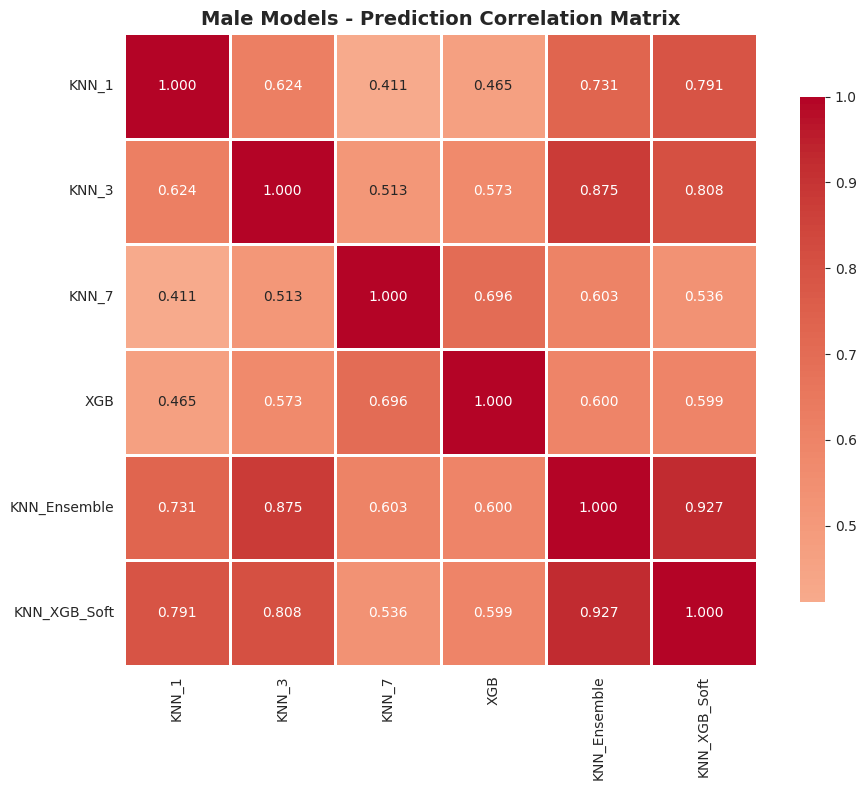


予測一致率（同じ予測をする割合）:
  KNN_1 vs KNN_3: 0.899
  KNN_1 vs KNN_7: 0.858
  KNN_1 vs XGB: 0.870
  KNN_1 vs KNN_Ensemble: 0.927
  KNN_1 vs KNN_XGB_Soft: 0.942
  KNN_3 vs KNN_7: 0.903
  KNN_3 vs XGB: 0.914
  KNN_3 vs KNN_Ensemble: 0.972
  KNN_3 vs KNN_XGB_Soft: 0.957
  KNN_7 vs XGB: 0.959
  KNN_7 vs KNN_Ensemble: 0.931
  KNN_7 vs KNN_XGB_Soft: 0.916
  XGB vs KNN_Ensemble: 0.931
  XGB vs KNN_XGB_Soft: 0.927
  KNN_Ensemble vs KNN_XGB_Soft: 0.985


In [7]:
# 男性モデルの予測を取得
print("男性モデルの相関分析（CV予測ベース）\n")

male_predictions = {}
for model_name, model in male_models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    # cross_val_predictでCV予測を取得
    male_predictions[model_name] = cross_val_predict(pipeline, X_m, y_m, cv=15, n_jobs=-1)

# DataFrameに変換
male_pred_df = pd.DataFrame(male_predictions)

# 相関行列を計算
male_corr = male_pred_df.corr()

print("相関行列:")
print(male_corr.round(3))

# ヒートマップ
plt.figure(figsize=(10, 8))
sns.heatmap(male_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Male Models - Prediction Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 一致率も確認
print("\n予測一致率（同じ予測をする割合）:")
for i, model1 in enumerate(male_models.keys()):
    for model2 in list(male_models.keys())[i+1:]:
        agreement = (male_pred_df[model1] == male_pred_df[model2]).mean()
        print(f"  {model1} vs {model2}: {agreement:.3f}")

女性モデルの相関分析（CV予測ベース）

相関行列:
               KNN_4  KNN_9  KNN_11    XGB  KNN_Ensemble  KNN_XGB_Softb
KNN_4          1.000  0.586   0.564  0.586         0.660          0.628
KNN_9          0.586  1.000   0.744  0.709         0.899          0.767
KNN_11         0.564  0.744   1.000  0.631         0.872          0.631
XGB            0.586  0.709   0.631  1.000         0.685          0.942
KNN_Ensemble   0.660  0.899   0.872  0.685         1.000          0.738
KNN_XGB_Softb  0.628  0.767   0.631  0.942         0.738          1.000


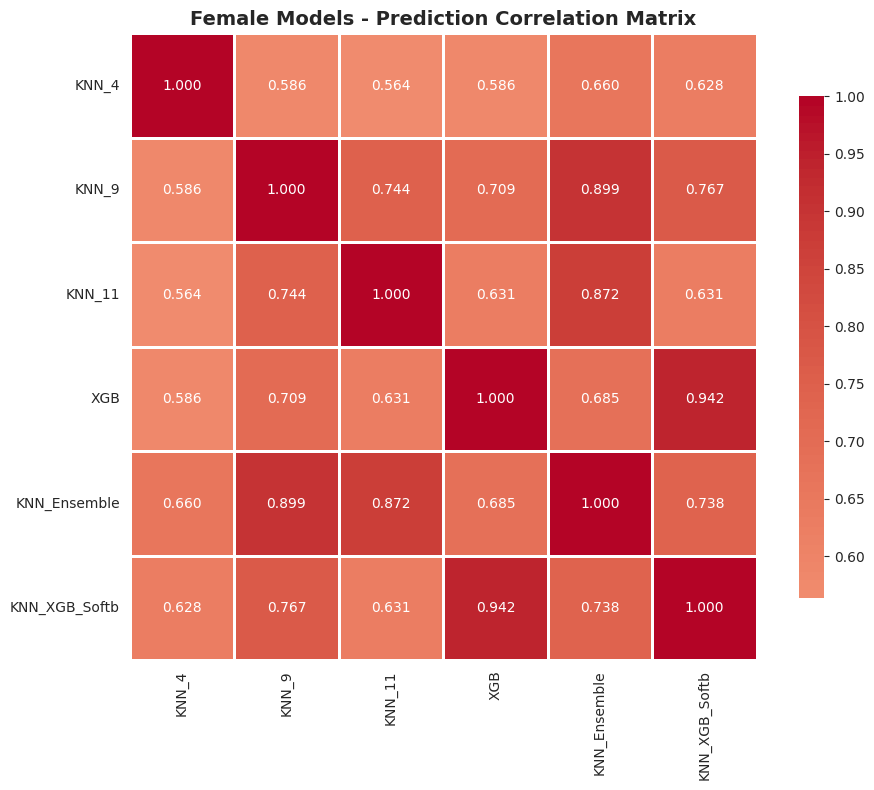


予測一致率（同じ予測をする割合）:
  KNN_4 vs KNN_9: 0.874
  KNN_4 vs KNN_11: 0.869
  KNN_4 vs XGB: 0.874
  KNN_4 vs KNN_Ensemble: 0.894
  KNN_4 vs KNN_XGB_Softb: 0.884
  KNN_9 vs KNN_11: 0.955
  KNN_9 vs XGB: 0.949
  KNN_9 vs KNN_Ensemble: 0.980
  KNN_9 vs KNN_XGB_Softb: 0.960
  KNN_11 vs XGB: 0.934
  KNN_11 vs KNN_Ensemble: 0.975
  KNN_11 vs KNN_XGB_Softb: 0.934
  XGB vs KNN_Ensemble: 0.939
  XGB vs KNN_XGB_Softb: 0.990
  KNN_Ensemble vs KNN_XGB_Softb: 0.949


In [8]:
# 女性モデルの相関分析
print("女性モデルの相関分析（CV予測ベース）\n")

female_predictions = {}
for model_name, model in female_models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    female_predictions[model_name] = cross_val_predict(pipeline, X_f, y_f, cv=9, n_jobs=-1)

female_pred_df = pd.DataFrame(female_predictions)
female_corr = female_pred_df.corr()

print("相関行列:")
print(female_corr.round(3))

plt.figure(figsize=(10, 8))
sns.heatmap(female_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Female Models - Prediction Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n予測一致率（同じ予測をする割合）:")
for i, model1 in enumerate(female_models.keys()):
    for model2 in list(female_models.keys())[i+1:]:
        agreement = (female_pred_df[model1] == female_pred_df[model2]).mean()
        print(f"  {model1} vs {model2}: {agreement:.3f}")

## モデルダイバーシティ分析

In [9]:
print("=" * 80)
print("MODEL DIVERSITY ANALYSIS")
print("=" * 80)

print("\n### MALE MODELS ###")
print("\n平均相関係数（自分自身を除く）:")
for model in male_corr.columns:
    avg_corr = male_corr[model].drop(model).mean()
    print(f"  {model:20s}: {avg_corr:.3f} {'(低相関=多様)' if avg_corr < 0.85 else '(高相関=類似)'}")

print("\n### FEMALE MODELS ###")
print("\n平均相関係数（自分自身を除く）:")
for model in female_corr.columns:
    avg_corr = female_corr[model].drop(model).mean()
    print(f"  {model:20s}: {avg_corr:.3f} {'(低相関=多様)' if avg_corr < 0.85 else '(高相関=類似)'}")

print("\n" + "=" * 80)
print("💡 解釈:")
print("  - 相関が低い（<0.85）= モデルが多様な予測 → アンサンブルで性能向上の可能性")
print("  - 相関が高い（>0.90）= モデルが似た予測 → アンサンブルの効果は限定的")
print("=" * 80)

MODEL DIVERSITY ANALYSIS

### MALE MODELS ###

平均相関係数（自分自身を除く）:
  KNN_1               : 0.605 (低相関=多様)
  KNN_3               : 0.679 (低相関=多様)
  KNN_7               : 0.552 (低相関=多様)
  XGB                 : 0.587 (低相関=多様)
  KNN_Ensemble        : 0.747 (低相関=多様)
  KNN_XGB_Soft        : 0.732 (低相関=多様)

### FEMALE MODELS ###

平均相関係数（自分自身を除く）:
  KNN_4               : 0.605 (低相関=多様)
  KNN_9               : 0.741 (低相関=多様)
  KNN_11              : 0.688 (低相関=多様)
  XGB                 : 0.710 (低相関=多様)
  KNN_Ensemble        : 0.771 (低相関=多様)
  KNN_XGB_Softb       : 0.741 (低相関=多様)

💡 解釈:
  - 相関が低い（<0.85）= モデルが多様な予測 → アンサンブルで性能向上の可能性
  - 相関が高い（>0.90）= モデルが似た予測 → アンサンブルの効果は限定的


## ベストモデルで予測

In [10]:
import os

best_male_model_name = male_results_df.iloc[0]['Model']
best_female_model_name = female_results_df.iloc[0]['Model']

print("ベストモデル:")
print(f"Male:   {best_male_model_name} (Acc: {male_results_df.iloc[0]['Accuracy']:.4f})")
print(f"Female: {best_female_model_name} (Acc: {female_results_df.iloc[0]['Accuracy']:.4f})")

# 訓練と予測
best_male_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', male_models[best_male_model_name])])
best_female_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', female_models[best_female_model_name])])

best_male_pipeline.fit(X_m, y_m)
best_female_pipeline.fit(X_f, y_f)

predictions_m = best_male_pipeline.predict(test_male[features])
predictions_f = best_female_pipeline.predict(test_female[features])

# Predict更新
mask_male = (data.index >= 891) & (data.index <= 1308) & (data.Sex=='male') & (data.WCSurvived.isnull())
data.loc[mask_male, 'Predict'] = predictions_m

mask_female = (data.index >= 891) & (data.index <= 1308) & (data.Sex=='female') & (data.WCSurvived.isnull())
data.loc[mask_female, 'Predict'] = predictions_f

# 提出ファイル
output = pd.DataFrame({
    'PassengerId': data[891:1309].PassengerId, 
    'Perished': (1 - data[891:1309].Predict).astype('int')
})

os.makedirs('../output', exist_ok=True)
filename = f'wcg_knn_xgb_{best_male_model_name}_{best_female_model_name}.csv'
output.to_csv(f'../output/{filename}', index=False)

print(f"\n提出ファイル: {filename}")
print(f"生存率: {(output['Perished'] == 0).sum() / len(output) * 100:.2f}%")

ベストモデル:
Male:   KNN_7 (Acc: 0.8437)
Female: KNN_9 (Acc: 0.8232)

提出ファイル: wcg_knn_xgb_KNN_7_KNN_9.csv
生存率: 35.65%


## サマリー

In [ ]:
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print("\n### MALE MODELS ###")
# Format with mean ± std for each metric
male_display = male_results_df.copy()
male_display['Accuracy_Display'] = male_display.apply(lambda x: f"{x['Accuracy']:.4f} ± {x['Accuracy_Std']:.4f}", axis=1)
male_display['Precision_Display'] = male_display.apply(lambda x: f"{x['Precision']:.4f} ± {x['Precision_Std']:.4f}", axis=1)
male_display['Recall_Display'] = male_display.apply(lambda x: f"{x['Recall']:.4f} ± {x['Recall_Std']:.4f}", axis=1)
male_display['F1_Display'] = male_display.apply(lambda x: f"{x['F1']:.4f} ± {x['F1_Std']:.4f}", axis=1)
print(male_display[['Model', 'Accuracy_Display', 'Precision_Display', 'Recall_Display', 'F1_Display']].to_string(index=False))

print("\n### FEMALE MODELS ###")
female_display = female_results_df.copy()
female_display['Accuracy_Display'] = female_display.apply(lambda x: f"{x['Accuracy']:.4f} ± {x['Accuracy_Std']:.4f}", axis=1)
female_display['Precision_Display'] = female_display.apply(lambda x: f"{x['Precision']:.4f} ± {x['Precision_Std']:.4f}", axis=1)
female_display['Recall_Display'] = female_display.apply(lambda x: f"{x['Recall']:.4f} ± {x['Recall_Std']:.4f}", axis=1)
female_display['F1_Display'] = female_display.apply(lambda x: f"{x['F1']:.4f} ± {x['F1_Std']:.4f}", axis=1)
print(female_display[['Model', 'Accuracy_Display', 'Precision_Display', 'Recall_Display', 'F1_Display']].to_string(index=False))

print("\n### KEY INSIGHTS ###")
print(f"\n1. ベストモデル:")
print(f"   Male: {best_male_model_name}")
print(f"   Female: {best_female_model_name}")

# KNN_XGB_Softとの比較
if 'KNN_XGB_Soft' in male_results_df['Model'].values:
    knn_xgb_male = male_results_df[male_results_df['Model'] == 'KNN_XGB_Soft'].iloc[0]
    knn_only_male = male_results_df[male_results_df['Model'] == 'KNN_Ensemble'].iloc[0]
    improvement_male = knn_xgb_male['Accuracy'] - knn_only_male['Accuracy']
    print(f"\n2. XGBoost追加の効果（Male）:")
    print(f"   KNN_Ensemble:  {knn_only_male['Accuracy']:.4f} ± {knn_only_male['Accuracy_Std']:.4f}")
    print(f"   KNN_XGB_Soft:  {knn_xgb_male['Accuracy']:.4f} ± {knn_xgb_male['Accuracy_Std']:.4f}")
    print(f"   改善:          {improvement_male:+.4f} ({'+' if improvement_male > 0 else ''}{improvement_male*100:.2f}%)")

if 'KNN_XGB_Softb' in female_results_df['Model'].values:
    knn_xgb_female = female_results_df[female_results_df['Model'] == 'KNN_XGB_Softb'].iloc[0]
    knn_only_female = female_results_df[female_results_df['Model'] == 'KNN_Ensemble'].iloc[0]
    improvement_female = knn_xgb_female['Accuracy'] - knn_only_female['Accuracy']
    print(f"\n3. XGBoost追加の効果（Female）:")
    print(f"   KNN_Ensemble:  {knn_only_female['Accuracy']:.4f} ± {knn_only_female['Accuracy_Std']:.4f}")
    print(f"   KNN_XGB_Softb: {knn_xgb_female['Accuracy']:.4f} ± {knn_xgb_female['Accuracy_Std']:.4f}")
    print(f"   改善:          {improvement_female:+.4f} ({'+' if improvement_female > 0 else ''}{improvement_female*100:.2f}%)")

print("\n" + "=" * 80)